# House Price Prediction using Machine Learning

This project builds an end-to-end machine learning pipeline to predict residential house prices using structured tabular data. The focus is on clean preprocessing, model evaluation, overfitting analysis, and interpretability rather than leaderboard optimization.

The project demonstrates how tree based models can capture non linear relationships in real world housing data while maintaining reproducibility and explainability.

### Environment + Imports 

In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

### Loading the data

In [24]:
data = pd.read_csv("G:/house-price-ml/Data/train.csv")

## Dataset Overview

The dataset contains 1,460 observations with a mix of numerical and categorical features describing residential properties. The target variable is `SalePrice`. Several features contain missing values, requiring a structured preprocessing strategy.


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Exploratory Data Analysis

Initial exploration focused on understanding the target distribution and identifying missing values. The target variable shows a right-skewed distribution, motivating the use of robust, tree-based models.


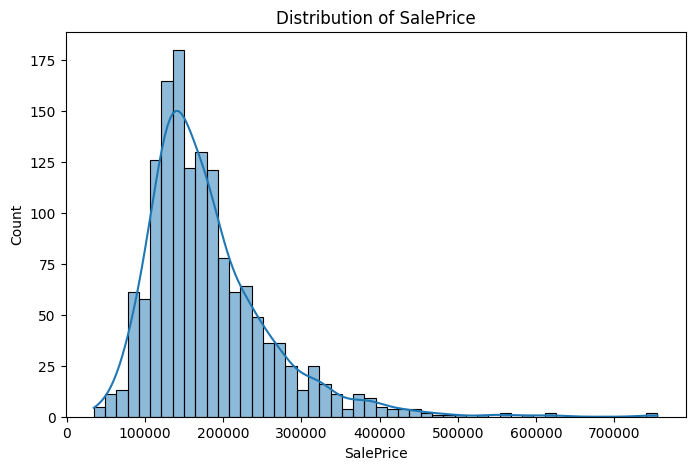

In [26]:
plt.figure(figsize=(8, 5))
sns.histplot(y, bins=50, kde=True)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.show()

In [27]:
missing = (
    data.isnull()
    .mean()
    .sort_values(ascending=False)
)

missing[missing > 0].head(10)


PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
MasVnrType      0.597260
FireplaceQu     0.472603
LotFrontage     0.177397
GarageQual      0.055479
GarageFinish    0.055479
GarageType      0.055479
dtype: float64

### Defining target and features

In [28]:
X = data.drop("SalePrice", axis=1)
y = data["SalePrice"]

SalePrice is the target variable representing the final sale price of a house.
All remaining columns are used as input features.

### Identifying numerical and categorical column

In [29]:
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns

len(numerical_cols), len(categorical_cols)

(37, 43)

### Train Validation Split

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

The dataset is split into training and validation sets to evaluate how well the model generalizes to unseen data.

## Building Preprocessing Pipelines

### Preprocessing Strategy

To avoid data leakage and ensure reproducibility, preprocessing was implemented using scikit-learn pipelines. Numerical features were imputed using the median, while categorical features were imputed using the most frequent value and one-hot encoded.


In [31]:
from sklearn.impute import SimpleImputer

numerical_transformer = SimpleImputer(strategy="median")

### Categorical pipeline

In [32]:
from sklearn.preprocessing import OneHotEncoder

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

### Combining with ColumnTransformer

In [33]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

Numerical features are imputed using the median to reduce the impact of outliers.
Categorical features are imputed using the most frequent value and encoded using one hot encoding.

## Baseline Model: Linear Regression

A linear regression model was trained as a baseline to establish a performance reference point.


In [34]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

### Combining preprocessing and modeling in a Pipeline

In [35]:
from sklearn.pipeline import Pipeline

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

### Training the model

In [36]:
clf.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

### Evaulating with a real metric

In [37]:
from sklearn.metrics import mean_absolute_error

preds = clf.predict(X_valid)
mae = mean_absolute_error(y_valid, preds)

mae

17523.679109589037

The Mean Absolute Error represents the average difference between the predicted and actual house prices.
This metric is chosen because it is easy to interpret in real world monetary terms.

In [38]:
from sklearn.linear_model import LinearRegression

lin_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

lin_model.fit(X_train, y_train)

lin_preds = lin_model.predict(X_valid)
lin_mae = mean_absolute_error(y_valid, lin_preds)

lin_mae

20485.659297118313

Linear Regression is used as a simple baseline model to understand how much improvement more complex models provide.

| Model                    | MAE     |
|--------------------------|---------|
| Linear Regression        | ~20,486 |
| Random Forest (baseline) | ~17,523 |


The Random Forest model significantly outperforms the linear baseline, indicating the presence of non linear relationships in the data.

## Random Forest Model

A Random Forest Regressor was selected due to its ability to model non-linear relationships and feature interactions in structured data.


In [39]:
rf_tuned = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_tuned_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("model", rf_tuned)
])

rf_tuned_pipe.fit(X_train, y_train)

rf_tuned_preds = rf_tuned_pipe.predict(X_valid)
rf_tuned_mae = mean_absolute_error(y_valid, rf_tuned_preds)

rf_tuned_mae

17500.467118278855

In [40]:
train_preds = rf_tuned_pipe.predict(X_train)
train_mae = mean_absolute_error(y_train, train_preds)

train_mae, rf_tuned_mae

(7204.670732661415, 17500.467118278855)

Although tuning improved training performance significantly, validation MAE remained similar, indicating overfitting and limited generalization gains.

# Model Explainability

#### Get feature names from the fitted preprocessor

In [41]:
feature_names = rf_tuned_pipe.named_steps["preprocessor"].get_feature_names_out()

len(feature_names)

286

In [42]:
rf_model = rf_tuned_pipe.named_steps["model"]
importances = rf_model.feature_importances_

len(importances)

286

In [43]:
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

fi_df.head(10)

,feature,importance
4,num__OverallQual,0.561759
16,num__GrLivArea,0.123394
12,num__TotalBsmtSF,0.032864
14,num__2ndFlrSF,0.032086
9,num__BsmtFinSF1,0.027899
13,num__1stFlrSF,0.026103
3,num__LotArea,0.017674
27,num__GarageArea,0.015378
26,num__GarageCars,0.013726
6,num__YearBuilt,0.011516


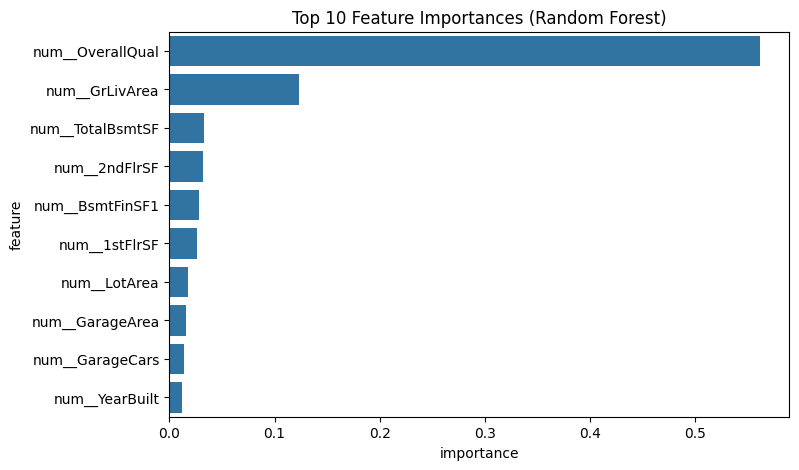

In [44]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=fi_df.head(10),
    x="importance",
    y="feature"
)
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

### Permutation Importance

In [45]:
X_valid_transformed = rf_tuned_pipe.named_steps["preprocessor"].transform(X_valid)

# Convert sparse matrix to dense array
X_valid_dense = X_valid_transformed.toarray()

In [46]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    rf_model,
    X_valid_dense,
    y_valid,
    n_repeats=10,
    random_state=42,
    scoring="neg_mean_absolute_error"
)

In [47]:
perm_df = pd.DataFrame({
    "feature": feature_names,
    "importance": perm.importances_mean
}).sort_values(by="importance", ascending=False)

perm_df.head(10)

,feature,importance
4,num__OverallQual,21709.250905
16,num__GrLivArea,10913.428334
12,num__TotalBsmtSF,2693.468273
9,num__BsmtFinSF1,1464.920246
13,num__1stFlrSF,1111.592074
27,num__GarageArea,1103.994521
3,num__LotArea,899.719545
26,num__GarageCars,877.890896
6,num__YearBuilt,869.846110
14,num__2ndFlrSF,791.767434


#### Clearly, better built houses with more usable living space, solid basements, and decent garages cost more.

## Explainability Insights

Permutation importance analysis shows that overall house quality and above ground living area are the strongest drivers of predicted sale prices. Basement related features and garage size also contribute significantly, reflecting the importance of usable living and storage space.

These results align with real world expectations of housing prices, suggesting that the model captures meaningful structural relationships rather than relying on spurious correlations.


## Conclusion

This project demonstrates a complete machine learning workflow, from preprocessing and model training to evaluation and interpretability. Emphasis was placed on building a clean, reproducible pipeline and validating model behavior through explainability techniques.
